In [1]:
import math
import numpy as np
import pandas as pd
import datetime 
import scipy.stats as stats
import matplotlib.pyplot as plt 
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv 
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega, delta 

python(53751) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [3]:
import time

def tic():
    global start_time
    start_time = time.time()

def toc():
    if 'start_time' in globals():
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time} seconds")
    else:
        print("Tic function has not been called yet.")

# Control Variates and Hedging 

## General Control Variates Equation

$C_{0} e^{rT} = C_{T} - \sum_{i=j}^{J} \beta_{j}cv_{j}+\eta$

where $\beta_{j}$ are linear factors coefficients and $\eta$ accounts for errors in the approximation.

### Delta Hedging

$ C_{t_{0}} e^{rT} - \sum_{i=0}^{N} \left[\left(\frac{\sigma C_{t_{i}}}{\sigma S} - \frac{\sigma C_{t_{i-1}}}{\sigma S}\right) S_{t} e^{r(T-t_{i})}\right] = C_{T} + \eta $

$\implies C_{t_{0}} e^{rT} = C_{T} - \left[\sum_{i=0}^{N-1} \frac{\sigma C_{t_{i}}}{\Delta S} \left(S_{t_{i+1}} - S_{t_{i}} e^{r\sigma t}\right)e^{r(T-t_{i+1})}\right] + \eta$

Here, the delta hedge is a delta-based martingale control variate ($cv_{1}$): 
$cv_{1} = \sum_{i=0}^{N-1} \frac{\sigma C_{t_{i}}}{\sigma S} \left(S_{t_{i+1}} - \mathbb{E}[S_{t_{i}}] \right) e^{r(T-t_{i+1})} $

$C_{t_{0}}e^{rT} = C_{T} - cv_{1} + \eta$

### Gamma Hedging

We can introduce another gamma-based martingale control variate ($cv_{2}$):
$cv_{2} = \sum_{i=0}^{N-1} \frac{\sigma^{2}C_{t_{i}}}{\sigma S^{2}}\left((\Delta S_{t_{i+1}})^{2} - \mathbb{E} \left[(\Delta S_{t_{i}})^{2}\right] \right) e^{r(T-t_{i+1})}$

where $\mathbb{E} \left[(\Delta S_{t_{i}})^{2}\right] = S_{t_{i}}^{2} (e^{\left[2r + \sigma^{2}\right]\Delta t_{i}} - 2e^{r\Delta t_{i}} + 1 ) $

In [19]:
# Demonstrating implementation of delta-based control variates

S = 101.15 # stock price
K = 98.01 # strike price
vol = 0.0991 # volatility (%)
r = 0.015 # risk-free rate (%)
N = 10 # number of time steps
M = 10 # number of simulations

market_value = 3.86 # market price of option 
T = ((datetime.date(2024,10,18) - datetime.date(2024,6,18)).days + 1)/365 # time in years
print(T)

0.336986301369863


### Slow solution 

In [20]:
tic() 
# Precomputing constants 
N = 10
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)

beta1 = -1

# Standard Error
sum_CT = 0
sum_CT2 = 0

# MC Method
for i in range(M):
    St = S
    cv = 0
    for j in range(N):
        epsilon = np.random.normal()
        deltaSt = delta('c', St, K, T-j*dt, r, vol)
        Stn = St*np.exp(nudt + volsdt*epsilon )
        cv = cv + deltaSt*(Stn - St*erdt)
        St = Stn

    CT = max(0, St - K) + beta1*cv
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Computing Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))
time.sleep(2)
toc()

Call value is $4.37 with SE +/- 0.199
Elapsed time: 2.009161949157715 seconds


### Vectorization for fast solution

In [21]:
def delta_calc(r, S, K, T, sigma, type="c"):
    "Calculate delta of an option"
    d1 = (np.log(S/K) + (r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    try: 
        if type == "c":
            delta_calc = stats.norm.cdf(d1, 0, 1)
        elif type == "p":
            delta_calc = -stats.norm.cdf(-d1, 0, 1)
        return delta_calc
    except: 
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")
        
tic()
# Precomputing constants 
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

erdt = np.exp(r*dt)
cv = 0
beta1 = -1

# MC Method
Z = np.random.normal(size=(N, M))
delta_St = nudt + volsdt*Z
ST = S*np.cumprod(np.exp(delta_St), axis=0)
ST = np.concatenate((np.full(shape=(1,M), fill_value=S), ST))
deltaSt = delta_calc(r, ST[:-1].T, K, np.linspace(T,0,N), vol, "c").T
cv = np.cumsum(deltaSt*(ST[1:] - ST[:-1]*erdt), axis=0)

CT = np.maximum(0, ST[-1] - K) + beta1*cv[-1]
C0 = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt(np.sum((np.exp(-r*T)*CT - C0)**2) / (M-1))
sigma = np.std(np.exp(-r*T)*CT)
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))
time.sleep(2)
toc()

Call value is $4.1 with SE +/- 0.39
Elapsed time: 2.016176700592041 seconds


### Comparison without Delta-based control variates 

In [22]:
tic()
# Precomputing constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

# MC Method
Z = np.random.normal(size=(N, M))
delta_St = nudt + volsdt*Z
ST = S*np.cumprod( np.exp(delta_St), axis=0)

CTw = np.maximum(0, ST[-1] - K)
C0w = np.exp(-r*T)*np.sum(CTw)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CTw - C0w)**2) / (M-1) )
SEw = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0w,2),np.round(SEw,3)))
time.sleep(2)
toc()

Call value is $6.12 with SE +/- 1.495
Elapsed time: 2.0076801776885986 seconds


### Visualization of convergence

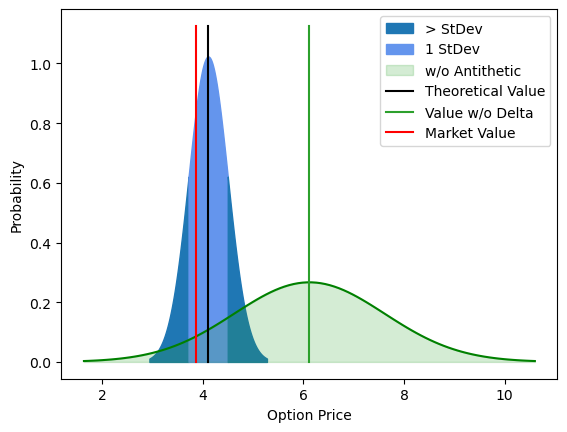

In [23]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
xw = np.linspace(C0w-3*SEw, C0w+3*SEw, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
sw = stats.norm.pdf(xw, C0w, SEw)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot(xw, sw, 'g-')
plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Antithetic')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([C0w,C0w],[0, max(s2)*1.1], color='tab:green',
        label='Value w/o Delta')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()